In [1]:
#.Packages
import os.path as path
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import fathon
from fathon import fathonUtils as fu
plt.style.use(['science','notebook'])

In [2]:
#.Data reading
url_darwin = 'https://crudata.uea.ac.uk/cru/data/soi/soi_dar.dat'
url_tahiti = 'https://crudata.uea.ac.uk/cru/data/soi/soi_tah.dat'
url_soi = 'https://crudata.uea.ac.uk/cru/data/soi/soi_3dp.dat'
urls = [url_darwin, url_tahiti, url_soi]

p_darwin = './data/soi_dar.dat'
p_tahiti = './data/soi_tah.dat'
p_soi = './data/soi_3dp.dat'
p_bei = './data/BEI.dat'

paths = [p_darwin, p_tahiti, p_soi, p_bei]
df = []
for i in range(4):
    p = paths[i]
    if path.exists(p):
        df.append(pd.read_table(paths[i], header=None, delim_whitespace=True))
    else:
        f.append(pd.read_table(urls[i], header=None, delim_whitespace=True))
        print("None")
darwin = df[0]
tahiti = df[1]
soi = df[2]
bei = df[3]

In [3]:
#.Data tidying

#.Rename columns
darwin.rename(columns={0: 'Year'},inplace=True)
tahiti.rename(columns={0: 'Year'},inplace=True)
soi.rename(columns={0: 'Year', 13:'Annual'},inplace=True)
bei.rename(columns={0: 'Year'},inplace=True)

#.Write nan values
darwin[darwin==-990]=np.nan
tahiti[tahiti==-990]=np.nan
soi[soi==99.990]=np.nan
soi[soi==-99.990]=np.nan
bei.rename(columns={0: 'Year'},inplace=True)

#.Pivot data
darwin = darwin.reset_index()
da=pd.melt(darwin, id_vars='Year', value_vars=[1,2,3,4,5,6,7,8,9,10,11,12],var_name='Month',value_name='Pressure')

tahiti = tahiti.reset_index()
ta=pd.melt(tahiti, id_vars='Year', value_vars=[1,2,3,4,5,6,7,8,9,10,11,12],var_name='Month',value_name='Pressure')

soi = soi.reset_index()
so=pd.melt(soi, id_vars='Year', value_vars=[1,2,3,4,5,6,7,8,9,10,11,12,'Annual'],var_name='Month',value_name='Pressure')

bei = bei.reset_index()
be=pd.melt(bei, id_vars='Year', value_vars=[1,2,3,4,5,6,7,8,9,10,11,12],var_name='Month',value_name='Pressure')

#.Drop nan values
so.dropna()
ta.dropna()
da.dropna()
be.dropna()

#Join all data
historical = da.merge(ta, how='inner', on=['Year','Month'])  #Add tahiti to darwin measurements
historical = historical.merge(so, how='inner', on=['Year','Month'])  #Add SOI index
historical = historical.rename(columns={'Pressure_x':'Darwin','Pressure_y':'Tahiti','Pressure':'SOI'}) 
#.Divide by 10 some measurements
historical['Darwin'] = historical['Darwin'] / 10
historical['Tahiti'] = historical['Tahiti'] / 10
historical.dropna()
historical.sort_values(by=['Year','Month'],inplace=True)
#.Dataframe with dates (without days)
dates = pd.to_datetime(historical['Month'].astype(str)+'/'+historical['Year'].astype(str)).dt.date.apply(lambda x: x.strftime('%Y-%m'))
darwin = historical['Darwin']
tahity = historical['Tahiti']
soi = historical['SOI']
year = historical['Year']
bei = be['Pressure']
year_2 = be['Year']

## MFDCCA analysis

In [4]:
a = fu.toAggregated(darwin)
b = fu.toAggregated(tahity)
c = fu.toAggregated(soi)

### Darwin vs Tahity

In [23]:
dar_tah_mfdcca = fathon.MFDCCA(a, b)
start = 10
#stop = len(a)/4
stop = 400
sStep = 5
winSizes = fu.linRangeByStep(start, stop, step=sStep)
polOrd = 1
revSeg = False
qs = np.arange(-8, 9, 0.5)

dar_tah_n, dar_tah_F = dar_tah_mfdcca.computeFlucVec(winSizes, qs, revSeg=revSeg, polOrd=polOrd)
list_H_dar_tah, list_H_intercept_dar_tah = dar_tah_mfdcca.fitFlucVec()

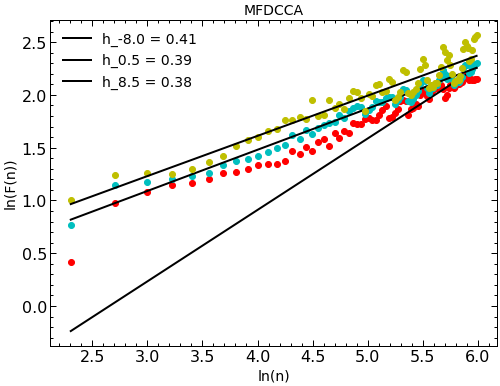

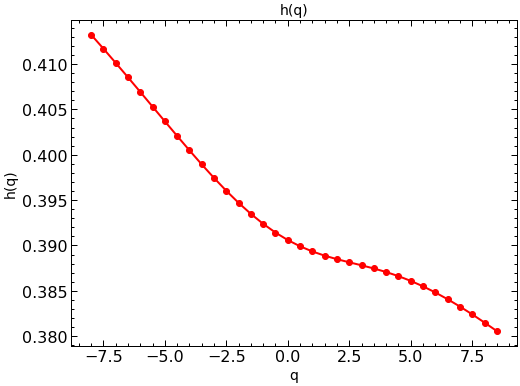

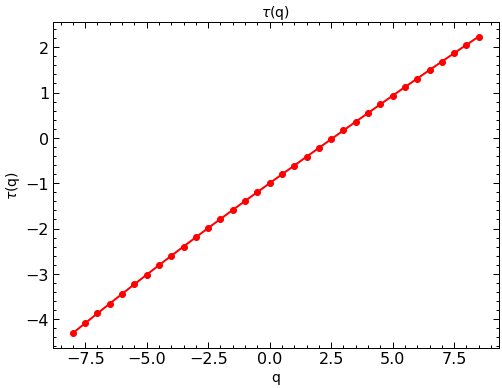

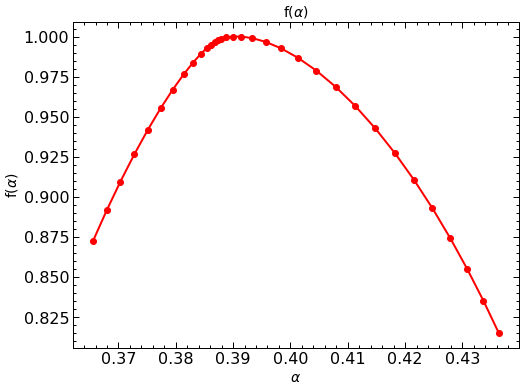

In [24]:
plt.plot(np.log(dar_tah_n), np.log(dar_tah_F[0, :]), 'ro')
plt.plot(np.log(dar_tah_n), list_H_intercept[0]+list_H[0]*np.log(dar_tah_n), 'k-', label='h_{:.1f} = {:.2f}'.format(qs[0], list_H_dar_tah[0]))
half_idx = int(len(qs)/2)
plt.plot(np.log(dar_tah_n), np.log(dar_tah_F[half_idx, :]), 'co')
plt.plot(np.log(dar_tah_n), list_H_intercept_dar_tah[half_idx]+list_H_dar_tah[half_idx]*np.log(dar_tah_n),
         'k-', label='h_{:.1f} = {:.2f}'.format(qs[half_idx], list_H_dar_tah[half_idx]))
plt.plot(np.log(dar_tah_n), np.log(dar_tah_F[-1, :]), 'yo')
plt.plot(np.log(dar_tah_n), list_H_intercept_dar_tah[-1]+list_H_dar_tah[-1]*np.log(dar_tah_n), 'k-',
         label='h_{:.1f} = {:.2f}'.format(qs[-1], list_H_dar_tah[-1]))
plt.xlabel('ln(n)', fontsize=14)
plt.ylabel('ln(F(n))', fontsize=14)
plt.title('MFDCCA', fontsize=14)
plt.legend(loc=0, fontsize=14)
plt.show()

plt.plot(qs, list_H_dar_tah, 'ro-')
plt.xlabel('q', fontsize=14)
plt.ylabel('h(q)', fontsize=14)
plt.title('h(q)', fontsize=14)
plt.show()

dar_tah_tau = dar_tah_mfdcca.computeMassExponents()

plt.plot(qs, dar_tah_tau, 'ro-')
plt.xlabel('q', fontsize=14)
plt.ylabel('$\\tau$(q)', fontsize=14)
plt.title('$\\tau$(q)', fontsize=14)
plt.show()

alpha_dar_tah, mfSpect_dar_tah = dar_tah_mfdcca.computeMultifractalSpectrum()

plt.plot(alpha_dar_tah, mfSpect_dar_tah, 'ro-')
plt.xlabel('$\\alpha$', fontsize=14)
plt.ylabel('f($\\alpha$)', fontsize=14)
plt.title('f($\\alpha$)', fontsize=14)
plt.show()

### Darwin vs SOI

In [26]:
dar_soi_mfdcca = fathon.MFDCCA(a, c)
start = 10
#stop = len(a)/4
stop = 400
sStep = 5
winSizes = fu.linRangeByStep(start, stop, step=sStep)
polOrd = 1
revSeg = False
qs = np.arange(-8, 9, 0.5)

dar_soi_n, dar_soi_F = dar_soi_mfdcca.computeFlucVec(winSizes, qs, revSeg=revSeg, polOrd=polOrd)
dar_soi_list_H, dar_soi_list_H_intercept = dar_soi_mfdcca.fitFlucVec()

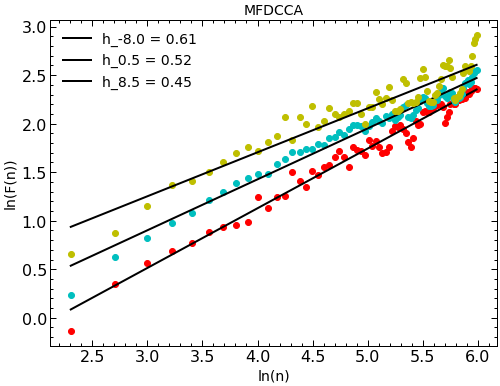

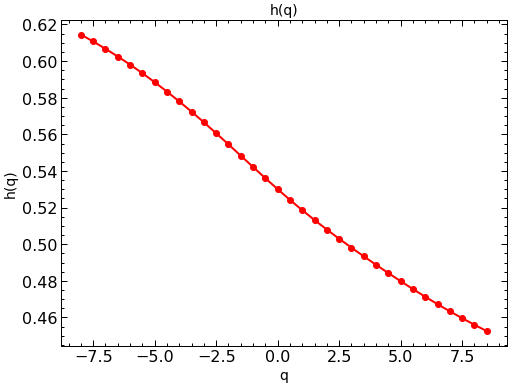

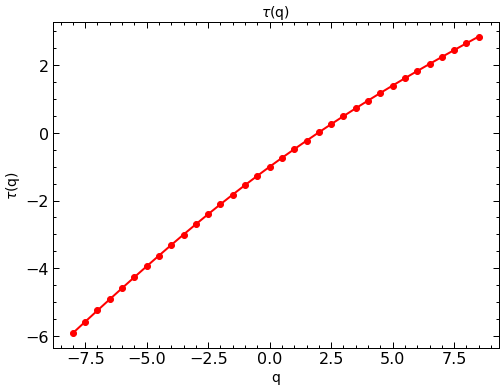

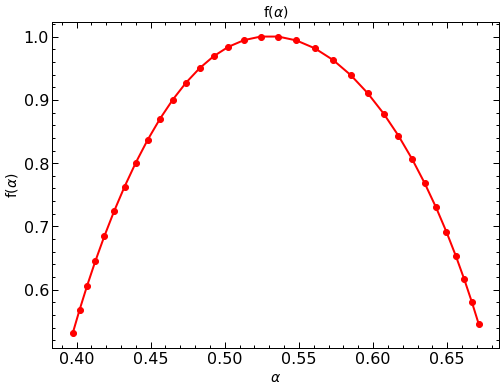

In [27]:
plt.plot(np.log(dar_soi_n), np.log(dar_soi_F[0, :]), 'ro')
plt.plot(np.log(dar_soi_n), dar_soi_list_H_intercept[0]+dar_soi_list_H[0]*np.log(dar_soi_n), 'k-', label='h_{:.1f} = {:.2f}'.format(qs[0], dar_soi_list_H[0]))
half_idx = int(len(qs)/2)
plt.plot(np.log(dar_soi_n), np.log(dar_soi_F[half_idx, :]), 'co')
plt.plot(np.log(dar_soi_n), dar_soi_list_H_intercept[half_idx]+dar_soi_list_H[half_idx]*np.log(dar_soi_n),
         'k-', label='h_{:.1f} = {:.2f}'.format(qs[half_idx], dar_soi_list_H[half_idx]))
plt.plot(np.log(dar_soi_n), np.log(F[-1, :]), 'yo')
plt.plot(np.log(dar_soi_n), dar_soi_list_H_intercept[-1]+dar_soi_list_H[-1]*np.log(dar_soi_n), 'k-',
         label='h_{:.1f} = {:.2f}'.format(qs[-1], dar_soi_list_H[-1]))
plt.xlabel('ln(n)', fontsize=14)
plt.ylabel('ln(F(n))', fontsize=14)
plt.title('MFDCCA', fontsize=14)
plt.legend(loc=0, fontsize=14)
plt.show()

plt.plot(qs, dar_soi_list_H, 'ro-')
plt.xlabel('q', fontsize=14)
plt.ylabel('h(q)', fontsize=14)
plt.title('h(q)', fontsize=14)
plt.show()

dar_soi_tau = dar_soi_mfdcca.computeMassExponents()

plt.plot(qs, dar_soi_tau, 'ro-')
plt.xlabel('q', fontsize=14)
plt.ylabel('$\\tau$(q)', fontsize=14)
plt.title('$\\tau$(q)', fontsize=14)
plt.show()

dar_soi_alpha, dar_soi_mfSpect = dar_soi_mfdcca.computeMultifractalSpectrum()

plt.plot(dar_soi_alpha, dar_soi_mfSpect, 'ro-')
plt.xlabel('$\\alpha$', fontsize=14)
plt.ylabel('f($\\alpha$)', fontsize=14)
plt.title('f($\\alpha$)', fontsize=14)
plt.show()

### Tahity vs SOI

In [28]:
tah_soi_mfdcca = fathon.MFDCCA(b, c)
start = 10
#stop = len(a)/4
stop = 400
sStep = 5
winSizes = fu.linRangeByStep(start, stop, step=sStep)
polOrd = 1
revSeg = False
qs = np.arange(-8, 9, 0.5)

tah_soi_n, tah_soi_F = tah_soi_mfdcca.computeFlucVec(winSizes, qs, revSeg=revSeg, polOrd=polOrd)
tah_soi_list_H, tah_soi_list_H_intercept = tah_soi_mfdcca.fitFlucVec()

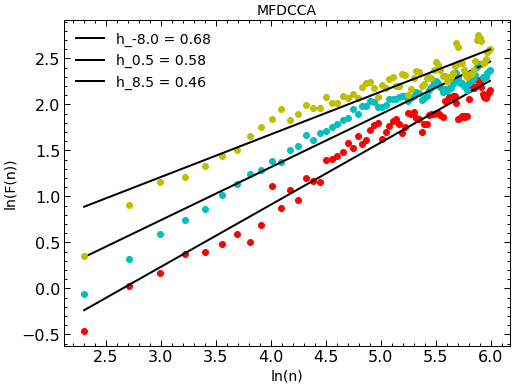

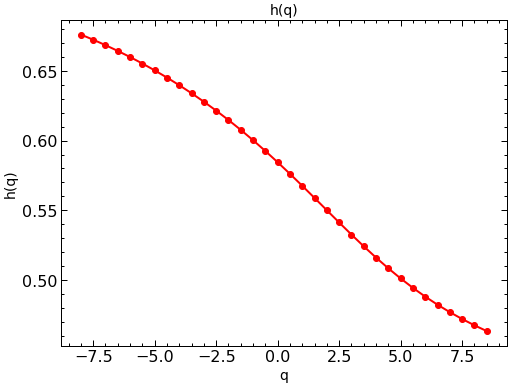

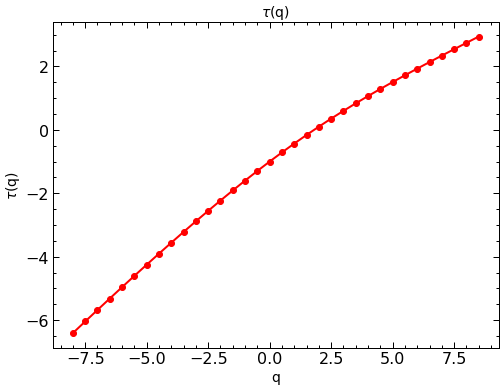

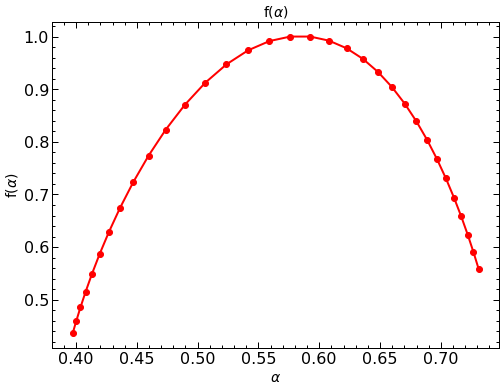

In [29]:
plt.plot(np.log(tah_soi_n), np.log(tah_soi_F[0, :]), 'ro')
plt.plot(np.log(tah_soi_n), tah_soi_list_H_intercept[0]+tah_soi_list_H[0]*np.log(tah_soi_n), 'k-', label='h_{:.1f} = {:.2f}'.format(qs[0], tah_soi_list_H[0]))
half_idx = int(len(qs)/2)
plt.plot(np.log(tah_soi_n), np.log(tah_soi_F[half_idx, :]), 'co')
plt.plot(np.log(tah_soi_n), tah_soi_list_H_intercept[half_idx]+tah_soi_list_H[half_idx]*np.log(tah_soi_n),
         'k-', label='h_{:.1f} = {:.2f}'.format(qs[half_idx], tah_soi_list_H[half_idx]))
plt.plot(np.log(tah_soi_n), np.log(tah_soi_F[-1, :]), 'yo')
plt.plot(np.log(tah_soi_n), tah_soi_list_H_intercept[-1]+list_H[-1]*np.log(tah_soi_n), 'k-',
         label='h_{:.1f} = {:.2f}'.format(qs[-1], list_H[-1]))
plt.xlabel('ln(n)', fontsize=14)
plt.ylabel('ln(F(n))', fontsize=14)
plt.title('MFDCCA', fontsize=14)
plt.legend(loc=0, fontsize=14)
plt.show()

plt.plot(qs, tah_soi_list_H, 'ro-')
plt.xlabel('q', fontsize=14)
plt.ylabel('h(q)', fontsize=14)
plt.title('h(q)', fontsize=14)
plt.show()

tah_soi_tau = tah_soi_mfdcca.computeMassExponents()

plt.plot(qs, tah_soi_tau, 'ro-')
plt.xlabel('q', fontsize=14)
plt.ylabel('$\\tau$(q)', fontsize=14)
plt.title('$\\tau$(q)', fontsize=14)
plt.show()

tah_soi_alpha, tah_soi_mfSpect = tah_soi_mfdcca.computeMultifractalSpectrum()

plt.plot(tah_soi_alpha, tah_soi_mfSpect, 'ro-')
plt.xlabel('$\\alpha$', fontsize=14)
plt.ylabel('f($\\alpha$)', fontsize=14)
plt.title('f($\\alpha$)', fontsize=14)
plt.show()

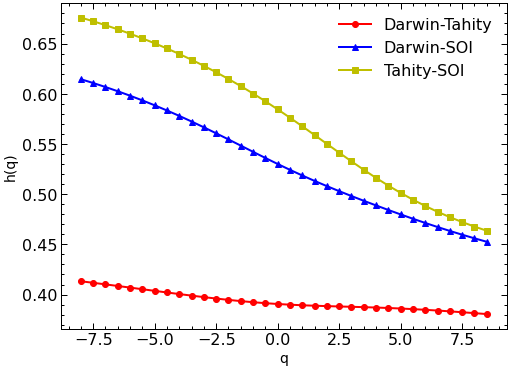

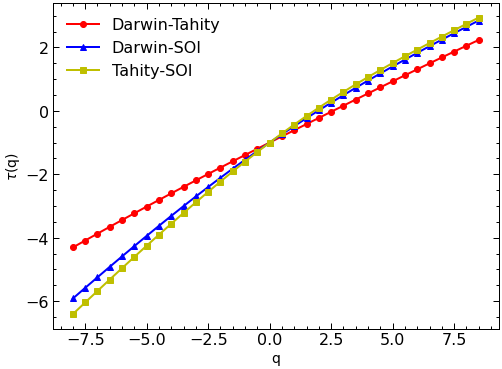

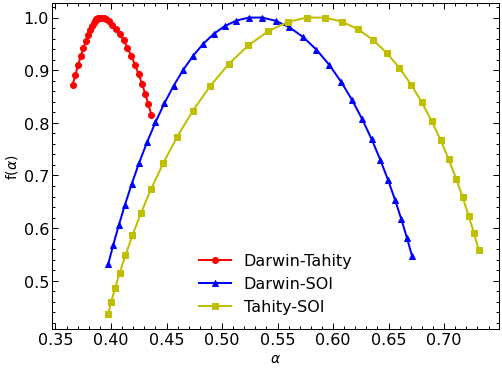

"\n###############################################################################33\n\n\nalpha_dar, mfSpect_dar = mfdfa_dar.computeMultifractalSpectrum()\nalpha_tah, mfSpect_tah = mfdfa_tah.computeMultifractalSpectrum()\nalpha_soi, mfSpect_soi = mfdfa_soi.computeMultifractalSpectrum()\nplt.plot(alpha_dar[:], mfSpect_dar[:], 'ro-', label='Darwin')\nplt.plot(alpha_tah[:], mfSpect_tah[:], 'b^-', label='Tahity')\nplt.plot(alpha_soi[:], mfSpect_soi[:], 'ys-', label='SOI')\nplt.xlabel('$\\alpha$', fontsize=14)\nplt.ylabel('f($\\alpha$)', fontsize=14)\n#plt.title('f($\\alpha$)', fontsize=14)\nplt.legend()\n#plt.savefig('fig/spectrum.pdf')\nplt.show()\n"

In [33]:
plt.plot(qs, list_H_dar_tah, 'ro-', label= 'Darwin-Tahity')
plt.plot(qs, dar_soi_list_H, 'b^-', label = 'Darwin-SOI')
plt.plot(qs, tah_soi_list_H, 'ys-', label = 'Tahity-SOI')
plt.xlabel('q', fontsize=14)
plt.ylabel('h(q)', fontsize=14)
#plt.title('h(q)', fontsize=14)
plt.legend()
#plt.savefig('fig/H.pdf')
plt.show()

plt.plot(qs, dar_tah_tau, 'ro-', label= 'Darwin-Tahity')
plt.plot(qs, dar_soi_tau, 'b^-', label = 'Darwin-SOI')
plt.plot(qs, tah_soi_tau, 'ys-', label = 'Tahity-SOI')
plt.xlabel('q', fontsize=14)
plt.ylabel('$\\tau$(q)', fontsize=14)
#plt.title('$\\tau$(q)', fontsize=14)
plt.legend()
#plt.savefig('fig/tau.pdf')
plt.show()

plt.plot(alpha_dar_tah, mfSpect_dar_tah,  'ro-', label= 'Darwin-Tahity')
plt.plot(dar_soi_alpha, dar_soi_mfSpect, 'b^-', label = 'Darwin-SOI')
plt.plot(tah_soi_alpha, tah_soi_mfSpect, 'ys-', label = 'Tahity-SOI')
plt.xlabel('$\\alpha$', fontsize=14)
plt.ylabel('f($\\alpha$)', fontsize=14)
#plt.title('f($\\alpha$)', fontsize=14)
plt.legend()
#plt.savefig('fig/spectrum.pdf')
plt.show()
'''
###############################################################################33


alpha_dar, mfSpect_dar = mfdfa_dar.computeMultifractalSpectrum()
alpha_tah, mfSpect_tah = mfdfa_tah.computeMultifractalSpectrum()
alpha_soi, mfSpect_soi = mfdfa_soi.computeMultifractalSpectrum()
plt.plot(alpha_dar[:], mfSpect_dar[:], 'ro-', label='Darwin')
plt.plot(alpha_tah[:], mfSpect_tah[:], 'b^-', label='Tahity')
plt.plot(alpha_soi[:], mfSpect_soi[:], 'ys-', label='SOI')
plt.xlabel('$\\alpha$', fontsize=14)
plt.ylabel('f($\\alpha$)', fontsize=14)
#plt.title('f($\\alpha$)', fontsize=14)
plt.legend()
#plt.savefig('fig/spectrum.pdf')
plt.show()
'''